In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from imblearn.over_sampling import SMOTE

from scipy import stats

%matplotlib inline
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
data = pd.read_csv('data/churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Значения столбцов таблицы:
* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и
*озвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которыми воспользовался клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).


Проверяем наличие пропусков:

In [4]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Смотрим на сбалансированность классов:

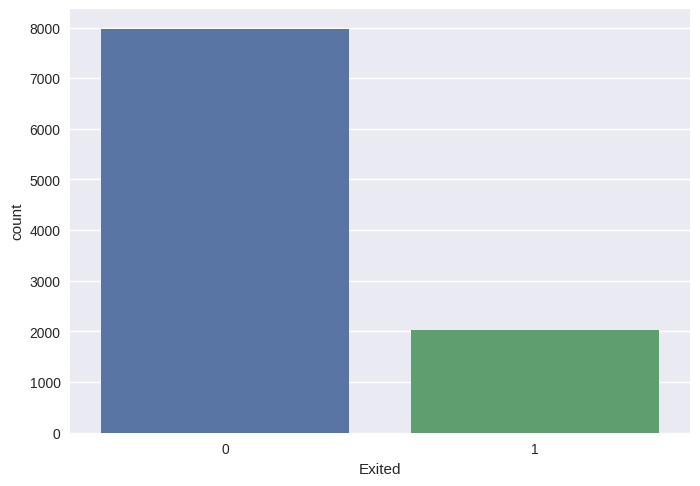

In [6]:
sns.countplot(data=data, x='Exited');

Для удобства переобозначим целевой признак (необязательный шаг):

In [7]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Исследуем категориальные признаки

In [8]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['Geography', 'Gender']

,Geography,Percentage
0,France,0.5014
1,Germany,0.2509
2,Spain,0.2477


,Gender,Percentage
0,Male,0.5457
1,Female,0.4543


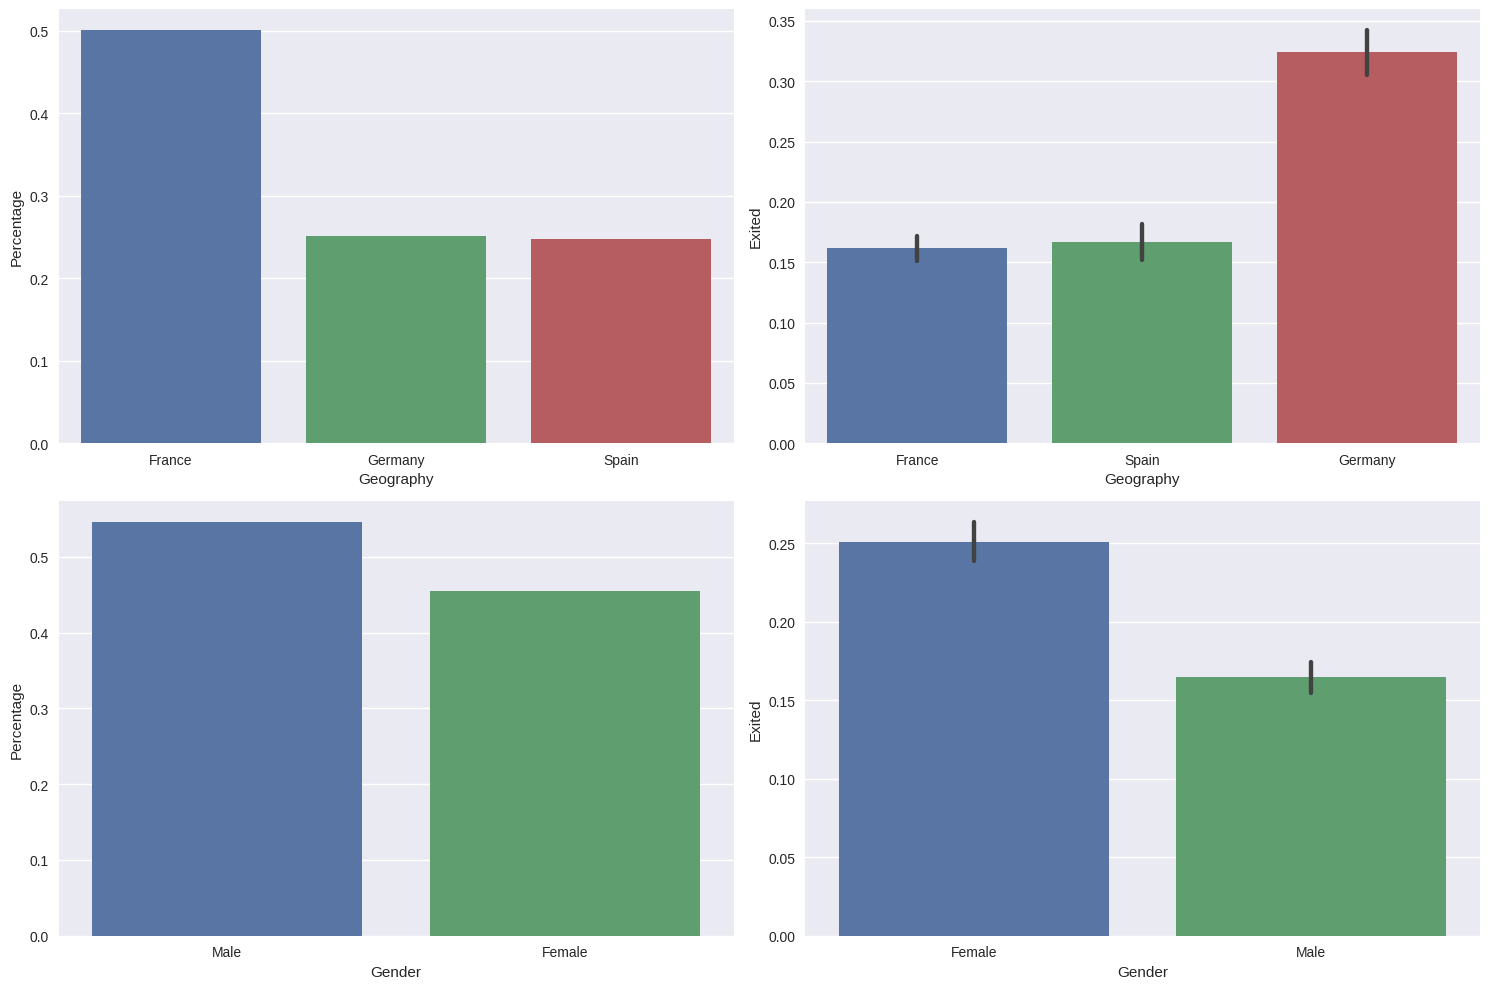

In [9]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 10)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('Percentage')
                  .reset_index())
    display(count_data)
    count_barplot = sns.barplot(data=count_data, x=feature, y='Percentage', ax=axes[i][0])
    mean_barplot = sns.barplot(data=data, x=feature, y='Exited', ax=axes[i][1])
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [10]:
data = pd.get_dummies(data, columns=cat_features, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


Предобрабатываем числовые признаки

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
# Применяем к CreditScore, Age, Tenure, Balance, NumOfProducts и EstimatedSalary
data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']] = min_max_scaler.fit_transform(data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])

# Переведем bool в int (Geography_Germany, Geography_Spain	Gender_Male)
data['Geography_Germany'] = data['Geography_Germany'].astype(int)
data['Geography_Spain'] = data['Geography_Spain'].astype(int)
data['Gender_Male'] = data['Gender_Male'].astype(int)


data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,0,0,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,0,0,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,0,0,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,1,0


Проверяем результаты предобработки

Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

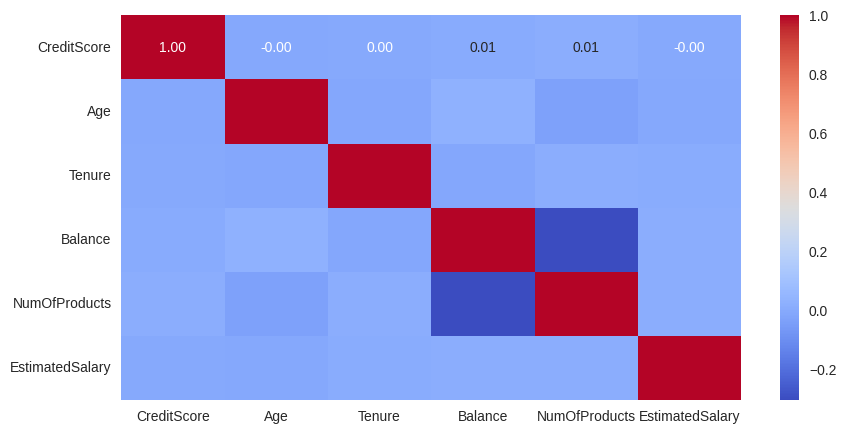

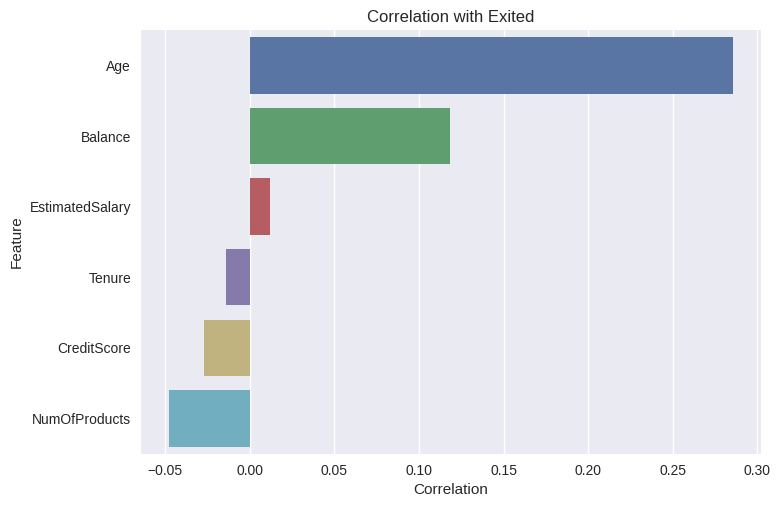

In [12]:
plt.figure(figsize = (10, 5))
sns.heatmap(data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

plt.show()

target = data['Exited']
continuous_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
correlations = {}
for f in continuous_features:
    data_temp = data[[f, 'Exited']]
    data_temp = data_temp[~data_temp[f].isnull()]
    correlations[f] = stats.pointbiserialr(data_temp['Exited'], data_temp[f])[0]
correlations = pd.Series(correlations)
correlations = correlations.sort_values(ascending=False)
sns.barplot(x=correlations, y=correlations.index)
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.title('Correlation with Exited')
plt.show()


Кодируем текстовые категориальные признаки

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [13]:
display(data.head())
X = data.drop(['Exited'], axis=1)
y = data['Exited']

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,0,0,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,0,0,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,0,0,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,1,0


Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

display(y_train.value_counts())
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
display(y_train.value_counts())

Exited
0    6370
1    1630
Name: count, dtype: int64

Exited
1    6370
0    6370
Name: count, dtype: int64

### Моделирование + оценка модели

Поиск параметров можно проводить с помощью численных методов. Например, градиентного спуска

In [15]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=100 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

Выводим отчет по метрикам для тренировочной и тестовой выборок

In [16]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6370
           1       0.72      0.70      0.71      6370

    accuracy                           0.71     12740
   macro avg       0.71      0.71      0.71     12740
weighted avg       0.71      0.71      0.71     12740

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1593
           1       0.39      0.71      0.50       407

    accuracy                           0.72      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.72      0.74      2000

